In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt

In [2]:
(train_X, train_Y), (test_X, test_Y) = load_data()
train_X = (np.float32(train_X) - 127.5) / 127.5

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
#Generator and Discriminator
class Generator(nn.Module):

  def __init__(self, input_dim=100, hidden_dim=1200, output_dim=28*28):
      super(Generator, self).__init__()

      self.network = nn.Sequential(
          nn.Linear(input_dim, hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim, hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim, output_dim),
          nn.Tanh()
      )


  def forward(self, z):
    return self.network(z)


class Discriminator(nn.Module):

  def __init__(self, input_dim=28*28, hidden_dim=240, output_dim=1):
      super(Discriminator, self).__init__()

      self.network = nn.Sequential(
          nn.Linear(input_dim, hidden_dim),
          nn.LeakyReLU(negative_slope=0.2),
          nn.Linear(hidden_dim, hidden_dim),
          nn.LeakyReLU(negative_slope=0.2),
          nn.Linear(hidden_dim, output_dim),
          nn.Sigmoid()
      )


  def forward(self, z):
    return self.network(z)


In [4]:
#Helpers

def sample_noise(batch_size, latent_size=100, device="cpu"):
  return torch.randn((batch_size, latent_size), device=device)


def sample_minibatch(batch_size, device="cpu"):
  indices = torch.randperm(train_X.shape[0])[:batch_size]
  return torch.from_numpy(train_X[indices]).to(torch.float).reshape(batch_size, -1).to(device)

In [5]:
#Training loop

def training_loop(generator, discriminator, generator_optimizer,
                  discriminator_optimizer,
                  nb_epochs,
                  k=1,
                  batch_size=100,
                  device='cpu'):
  training_loss = {"generator": [], "discriminator": []}

  for epoch in tqdm(range(nb_epochs)):

    #Train the discriminator
    for _ in range(k):
      #Sample minibatch of m noise samples
      z = sample_noise(batch_size, device=device)
      #Samle minibatch of m examples data
      x = sample_minibatch(batch_size, device=device)

      #Updating the discriminator
      f_loss = nn.BCELoss()(discriminator(generator(z)).squeeze(-1), torch.zeros(batch_size, device=device))
      r_loss = nn.BCELoss()(discriminator(x).squeeze(-1), torch.ones(batch_size, device=device))

      loss = (f_loss + r_loss) / 2.0
      discriminator_optimizer.zero_grad()
      loss.backward()
      discriminator_optimizer.step()
      training_loss["discriminator"].append(loss.item())

    #Train the generator
    #Sample minibatch of m noise samples
    z = sample_noise(batch_size, device=device)
    #Update the generator
    loss = nn.BCELoss()(discriminator(generator(z)).squeeze(-1), torch.ones(batch_size, device=device))

    generator_optimizer.zero_grad()
    loss.backward()
    generator_optimizer.step()
    training_loss["generator"].append(loss.item())


  return training_loss


In [6]:
#Putting everything together

device = 'cuda:0'
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_optimizer = torch.optim.SGD(generator.parameters(),
                                      lr=0.1,
                                      momentum=0.5,
                                      )

discriminator_optimizer = torch.optim.SGD(discriminator.parameters(),
                                      lr=0.1,
                                      momentum=0.5,
                                      )

training_loop(generator, discriminator, generator_optimizer, discriminator_optimizer, 50_000, k=1, batch_size=100, device=device)

100%|██████████| 50000/50000 [06:06<00:00, 136.50it/s]


{'generator': [0.6815945506095886,
  0.6793622970581055,
  0.6793349981307983,
  0.682751476764679,
  0.6852896809577942,
  0.6762164831161499,
  0.6643465757369995,
  0.6550811529159546,
  0.6713352203369141,
  0.7078319191932678,
  0.7590624690055847,
  0.7989227771759033,
  0.8024269938468933,
  0.7955273389816284,
  0.8018931150436401,
  0.8357061743736267,
  0.8475868105888367,
  0.8235186338424683,
  0.8210510015487671,
  0.8690241575241089,
  0.8697287440299988,
  0.9228550791740417,
  0.9903863072395325,
  0.9886184334754944,
  1.102192759513855,
  0.876422107219696,
  1.585559606552124,
  0.2552592158317566,
  1.977661371231079,
  1.206708312034607,
  0.7063330411911011,
  0.7554703950881958,
  1.0316201448440552,
  1.0868879556655884,
  0.9986564517021179,
  1.0420054197311401,
  1.114696979522705,
  1.0521844625473022,
  1.413161277770996,
  0.8474751114845276,
  2.079190969467163,
  0.5350959897041321,
  1.2208259105682373,
  1.2464977502822876,
  1.0157356262207031,
  1.61

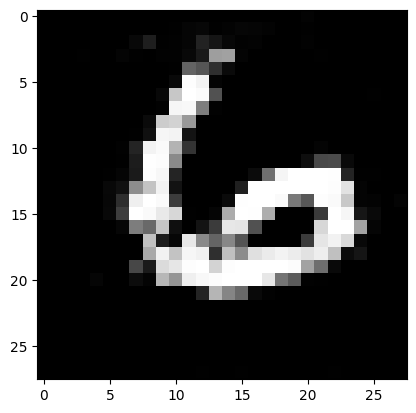

In [7]:
z = sample_noise(1, device=device)
x = generator(z)
plt.imshow(x[0].data.cpu().numpy().reshape(28, 28), cmap='gray')

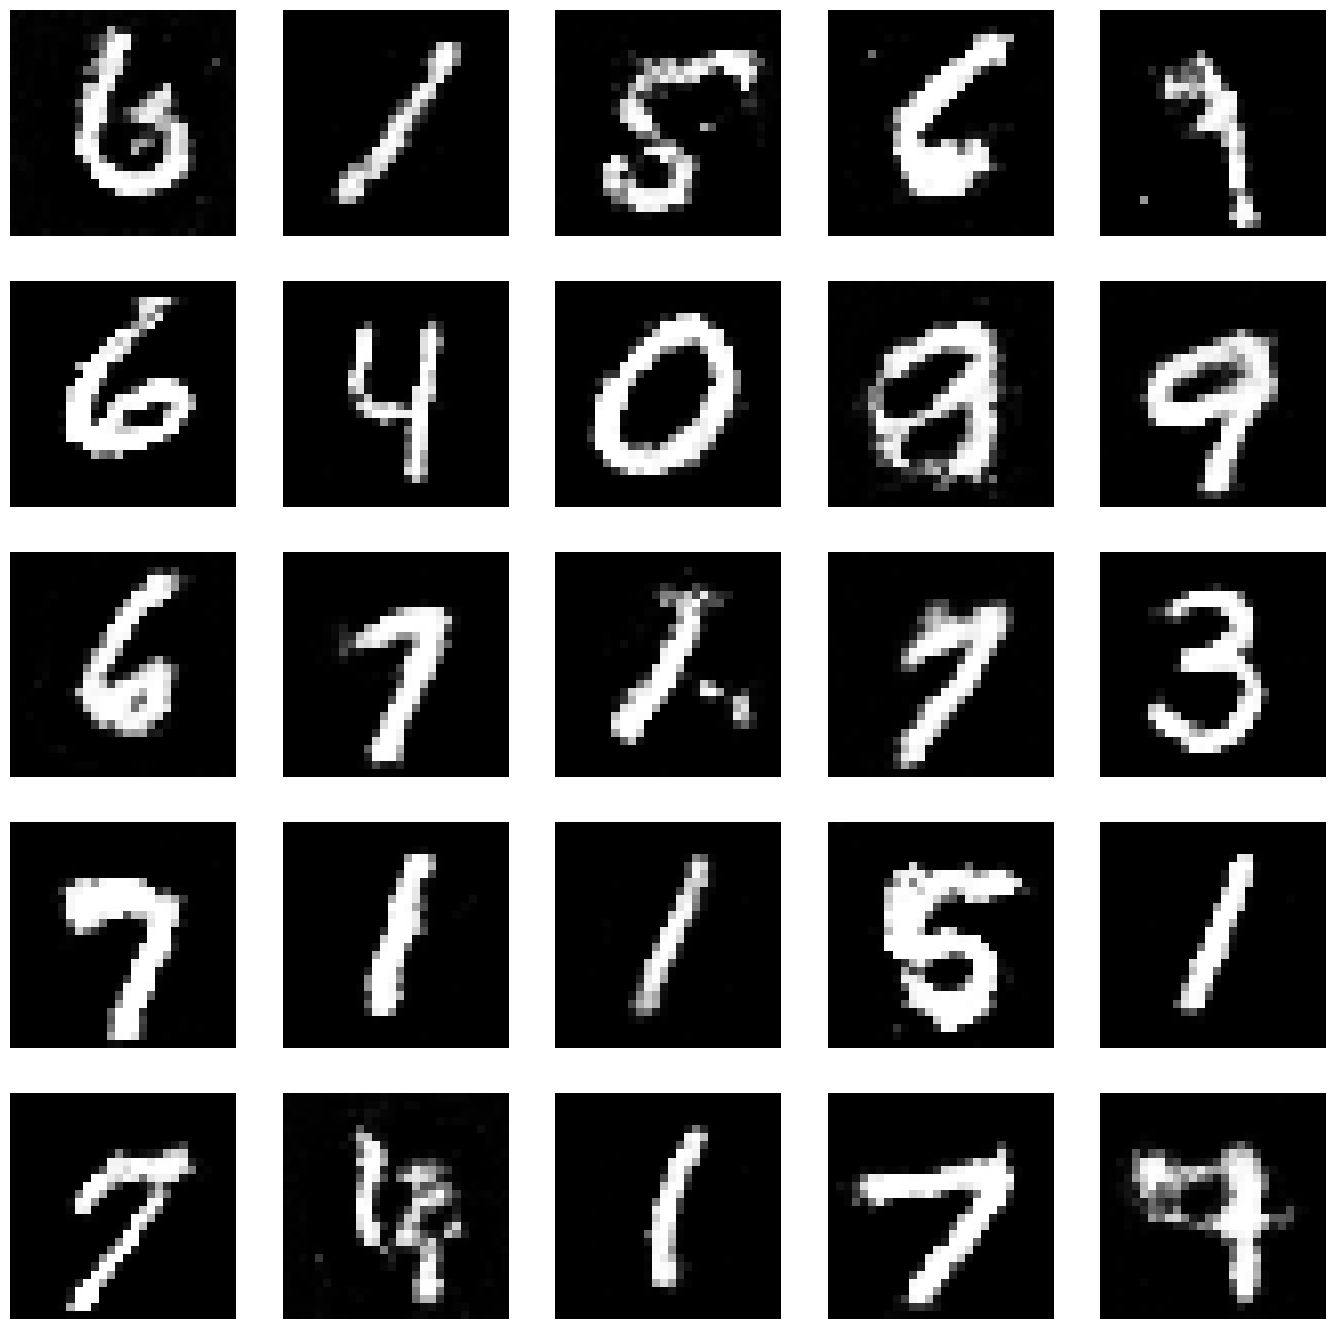

In [8]:
NB_IMAGES = 25
z = sample_noise(NB_IMAGES, device=device)
x = generator(z).data.cpu().numpy()

plt.figure(figsize=(17, 17))

for i in range(NB_IMAGES):
  plt.subplot(5, 5, 1 + i)
  plt.axis('off')
  plt.imshow(x[i].reshape(28, 28), cmap='gray')

plt.savefig('generated_samples.png')

In [4]:
sample_noise(100, device="cuda")

tensor([[-0.3666,  2.4880, -0.1845,  ...,  1.1586,  0.8829, -0.2453],
        [-0.7466, -1.1729,  0.7037,  ...,  0.1039, -0.3007, -1.3158],
        [ 0.2779,  0.1268,  0.9796,  ..., -0.0471,  0.1126, -0.8516],
        ...,
        [-0.4289,  0.3972,  1.2712,  ...,  0.5912,  1.0947,  0.1275],
        [-0.1425,  0.4888, -2.2036,  ..., -0.6772, -1.2039, -0.8038],
        [-0.4371,  1.4109, -2.1993,  ...,  0.9081,  0.2484, -1.1190]],
       device='cuda:0')

In [22]:
x = sample_minibatch(100, device="cpu")

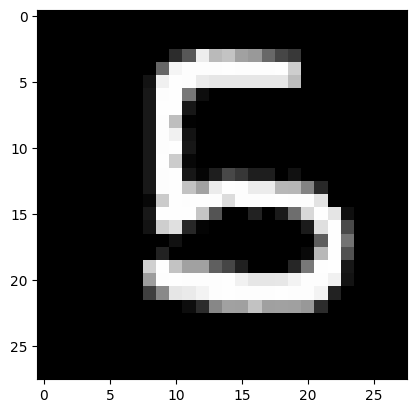

In [23]:
plt.imshow((x[0].numpy().reshape(28, 28) +1.)/2., cmap='gray')